# Install Modules

In [1]:
%pip install control
%pip install pygame
%pip install filterpy

Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 22.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 22.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You are using pip version 18.1, however version 22.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


^C
Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control
import math
import pendulum
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise

pygame 2.1.2 (SDL 2.0.18, Python 3.7.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Filtering
The following snippet generates a random walk and a noisy measurement of the random walk. Our objective is to estimate the random walk while only using the measurement.
For the first experiment, our disturbance and noise has a standard deviation of 1 and 5, respectively.

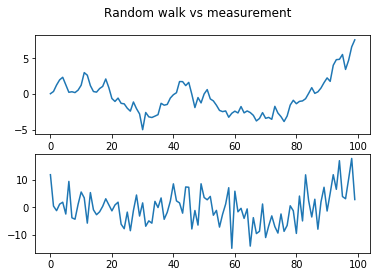

In [6]:
def walk_measurement(disturbance,noise):
    rwalk=[0]
    for i in range(99):
        #The next point of the the random walk is the current point + some normally distributed disturbances
        rwalk.append(rwalk[-1]+np.random.normal(0,disturbance))
    # We measure the random walk with some additional measurement noise
    measurement=[i+np.random.normal(0,noise) for i in rwalk]
    return rwalk,measurement
rwalk,measurement=walk_measurement(1,5)
fig, axs = plt.subplots(2)
fig.suptitle('Random walk vs measurement')
axs[0].plot(rwalk)
axs[1].plot(measurement)


We now try to estimate the random walk using the filter function. It takes our current estimate and measurement to return the current estimate.
Tasks:
- Vary the constant W and observe the effect it has on the filtered sequence (how similar it is to the random walk)
- Compute the sqaured error between the filtered sequence and the random walk, the squared error between the measurement and the random walk, and print the ratio between them.
- Try to tune the constant to minimize the error ratio

0.33409143332596875


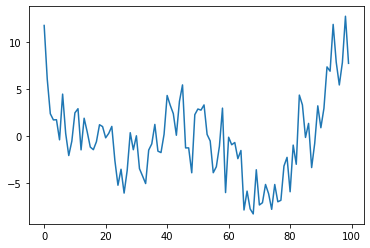

In [7]:
def filter(estimate,cur_measurement):
    w=0.5
    return estimate+w*(cur_measurement-estimate)
filtered=[measurement[0]]
for i in measurement[1:]:
    filtered.append(filter(filtered[-1],i))
plt.plot(filtered)
print(sum([(filtered[i]-rwalk[i])**2 for i in range(len(rwalk))])/sum([(measurement[i]-rwalk[i])**2 for i in range(len(rwalk))]))

We now change our disturbance and noise to have a variance of 5 and 3, respectively. Repeat the experiment and vary w in filter 2 to minimize the error ratio

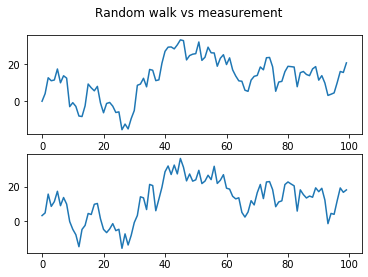

In [8]:
rwalk,measurement=walk_measurement(5,3)
fig, axs = plt.subplots(2)
fig.suptitle('Random walk vs measurement')
axs[0].plot(rwalk)
axs[1].plot(measurement)

0.8538754301423507


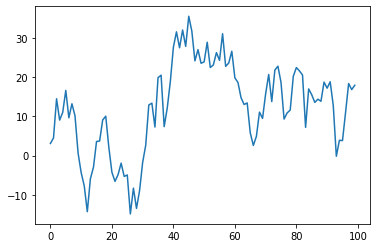

In [9]:
def filter2(prediction,cur_measurement):
    w=0.9
    return prediction+w*(cur_measurement-prediction)
filtered=[measurement[0]]
for i in measurement[1:]:
    filtered.append(filter2(filtered[-1],i))
plt.plot(filtered)
print(sum([(filtered[i]-rwalk[i])**2 for i in range(len(rwalk))])/sum([(measurement[i]-rwalk[i])**2 for i in range(len(rwalk))]))

# Alpha Beta filtering
   - The alpha beta filter(also known as g-h filter) assumes that there are two internal state, where the second state is the rate of change of the first state. For instance, an aircraft might need to estimate its position and velocity, but the velocity follows a random walk due to air resistance and we only have access to a noisy sensor that measures the position. The g-h filter estimates both position and velocity based on model prediction and current measurements.  The g parameter determines how much we trust predictions of position relative to measuremnt, while the h parameter determines how much we trust predictions of velocity relative to measurement(derived from change in position). 
   - The difference between the current measurement and estimate of position is called the residual. If the residual is positive, it might mean the previous estimate of position is low, or the previous estimate of velocity is low (since $x_{t+1}=x_t+v$), or some combination of both. The g and h parameters specify how much we should correct the position and velocity estimate, respectively. 

In [10]:
def aircraft(v_unc,x_unc):
    air=[0]
    v=2
    for i in range(99):
        air.append(air[-1]+v)
        v+=np.random.normal(0,v_unc)
    measure=[i+np.random.normal(0,x_unc) for i in air]
    return air, measure
# Parameters: Measured position data, initial velocity, g and h
def g_h_filter(data, v, g, h):
    x_est=data[0]
    filtered=[data[0]]
    for x in data[1:]:
        x_pred=x_est+v
        residual=x-x_pred
        v=v+h*(residual)
        x_est=x_pred+g*residual
        filtered.append(x_est)
    return filtered

# Task:
- Tune the parameters g and h so that the ratio between the error of filtered estimation and the error of measurement is minimized
- Change the variance in the uncertainties for velocity and measurement and repeat the experiment. How should g and h change to accomodate the changes in uncertainty?

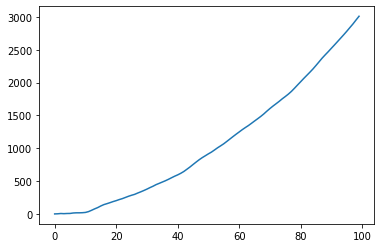

In [11]:
air,measure=aircraft(3,5)
filtered=g_h_filter(measure,2,0.6,0.9)
plt.plot(air)

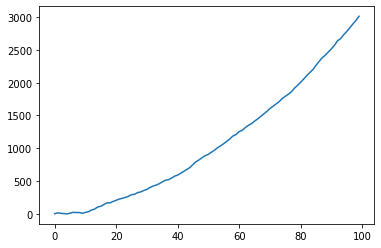

In [12]:
plt.plot(measure)

error ratio: 0.986503910657664


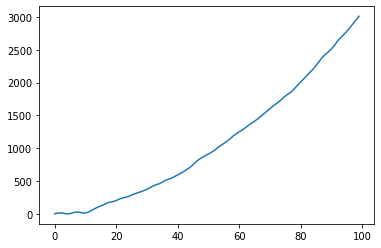

In [13]:
plt.plot(filtered)
print("error ratio:",sum([(filtered[i]-air[i])**2 for i in range(len(air))])/sum([(measure[i]-air[i])**2 for i in range(len(air))]))

## Inverted Pendulum
Our inverted pendulum has four variables in its state: The position, velocity, angle and angular velocity. We use the extended kalman filter to estimate the full state and feed it to our controller (the linear quadaratic regulator)

Task:
- Set our measurement uncertainty matrix (ekf.R) to 0.1 times the identity matrix (use np.eye(5)). This means that the measurement noise variance for each of our variable is 0.1
- Set our model disturbance uncertainty matrix (ekf.Q) to 0.01 times the identity matrix (use np.eye(5)). This means that the model disturbance variance for each of our variable is 0.01
- The true state of the system is x_true, our measurement is x and our estimate is ekf.x. Append the mean squared error of the estimate ($(ekf.x-x_{true})^2$) to the array "filtered"  and the mean squared error of the measurement ($(x-x_{true})^2$) to the array "nonfiltered" 

In [17]:

#x,x dot,theta, theta dot
WINDOWDIMS = (1200, 600)
CARTDIMS = (50, 10)
PENDULUMDIMS = (6, 200)
GRAVITY = 0.13
REFRESHFREQ = 100
A_CART = 0.15
inv = pendulum.InvertedPendulumGame(WINDOWDIMS, CARTDIMS, PENDULUMDIMS, GRAVITY, A_CART, REFRESHFREQ)
A_=None
B_=None
u=None
filtered=[]
nonfiltered=[]

def Hj(x):
    return np.eye(5)
def H(x):
    return x

ekf=ExtendedKalmanFilter(dim_x=5,dim_z=5,dim_u=1)
ekf.R=0.1*np.eye(5)
ekf.Q=0.01*np.eye(5)
def kalman(x,u):
    ekf.predict_update(x,Hj,H,u=u)
def controller(x,x_true):
    global ekf,A_,B_,u
    if u is None:
        ekf.x=x
    else:
        kalman(x,u=np.array([u]))
    nonfiltered.append(np.mean((x-x_true)**2))
    filtered.append(np.mean((ekf.x-x_true)**2))
    A=np.array([0,1,0,0,0,0,0,0,0,0,0,np.cos(x[2])/float(inv.pendulum.PENDULUMLENGTH),0,1,0,0,0,0,0,inv.pendulum.GRAVITY*np.sin(x[2])/float(inv.pendulum.PENDULUMLENGTH),0,0,0,0,0]).reshape(5,5)
    B=np.array([0,1,0,0,0]).reshape(5,1)
    C=np.eye(5)
    D=np.zeros((5,1))
    system=control.StateSpace(A,B,C,D,dt=1)
    Q=np.array([0,0,0,0,0,0,0,0,0,0,0,0,1000,0,0,0,0,0,10,0,0,0,0,0,0]).reshape(5,5)
    R=np.array([0])
    K,S,E=control.lqr(system,Q,R)
    u,ekf.F,ekf.B=-K[0].dot(ekf.x),A+np.eye(5),B
    return u
inv.game(controller)

SystemExit: 

Run the following snippet to plot the errors

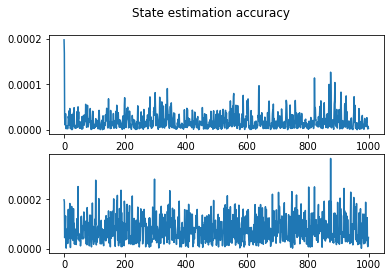

In [5]:
fig, axs = plt.subplots(2)
fig.suptitle('State estimation accuracy')
axs[0].plot(filtered[:1000])
axs[1].plot(nonfiltered[:1000])